# Simulating Language, Lab 4, Iterated Bayesian Learning

This simulation features a replication of the Reali & Griffiths iterated learning model of the evolution of frequency distributions, and is built around the Bayesian model of frequency learning/regularisation from Lab 3.  This simulation allows you to explore the effects of learning bias on cultural evolution. But before we get onto the model itself, we need to talk about log probabilities.

In [1]:
from math import log, exp

## Introduction to log probabilities

In the lectures I introduced Bayes’ Rule as a relationship between probabilities: the posterior is proportional to the product of the likelihood and the prior, and all three of these quantities are probabilities. Doing Bayesian models of learning therefore involves manipulating probabilities, numbers between 0 and 1. And some of these probabilities can be very small indeed, because they involve multiplying small numbers lots of times (consider, for instance, how small the probability is of getting 100 heads if you flip a fair coin 100 times: it’s 0.5 $\times$ 0.5 $\times$ 0.5 ... 100 times, or $0.5^{100}$ if you prefer. That’s a very small number.)

As I said in the Lab 3 worksheet (go back and check if you need a refresher), working with small numbers on a computer can be a problem, because the computer cannot exactly represent real numbers (i.e. numbers we would write in decimal notation, e.g. numbers like 0.1, 3.147). There’s no way your computer can exactly represent every possible real number, so what it does instead is store numbers as accurately as it can, which involves introducing small rounding errors.  

Why do you need to care about this? Well, if you are dealing with very very small numbers (as you might do if you were doing a Bayesian model which involves learning from lots of data) then the rounding errors become a real issue – for big numbers the rounding errors are so small (relative to the big numers) we don’t really care, but for very small numbers, the rounding errors might be relatively big. Worse, sometimes the computer will round a very very small number to 0, which can generate unexpected and hard-to-predict errors in your code (e.g., if you try to divide something by a very very small number which gets rounded to 0).  

The solution to this is to have the computer work not with probabilities, but with *log probabilities*: we take our probabilities, take the log of those numbers, then carry on as before. We can convert log probabilities back to probabilities with the `exp()` function, the inverse of the `log()` function.

In [2]:
print(log(1))
print(log(0.1))
print(log(0.000001))
print(exp(log(0.5)))
print(exp(log(0.1)))

0.0
-2.3025850929940455
-13.815510557964274
0.5
0.10000000000000002


As you can see from the code above, taking the log of a very small number turns it into a large negative number – these are still real numbers, so the computer still can’t represent them exactly, but in the log domain the rounding errors will be proportionately smaller for very small numbers and the rounding-to-0 problem won’t crop up. Then, if we want to see an actual probability, rather than a log probability, we can reverse this process, using the `exp()` function, to get back raw probabilities. Jumping back and forth from logs can introduce rounding errors of its own, but it’s necessary to avoid the catastrophic rounding errors you can get if you just work with raw probabilities. 

Some basic arithmetic operations work a bit differently with logs. If you want to multiply two probabilities, you *add* their logarithms; if you want to divide one probability by another, you *subtract* the logarithm of one from another. And there is no direct equivalent of adding and subtracting in the log domain, which involves a little bit of fancy footwork in the code that you don’t have to worry about too much. The important thing is 1) to understand that the code is going to manipulate log probabilities and 2) this changes nothing conceptually, it’s just a matter of implementation.

In [3]:
print(0.5 * 0.5)
print(exp(log(0.5) + log(0.5)))
print(0.5 / 0.5)
print(exp(log(0.5) - log(0.5)))

0.25
0.25
1.0
1.0


## On to the code

First, loading in the functions for random numbers and the beta distribution, plus some more that are specifically for doing stuff with logs. For instance, `logsumexp()` (which we get from the `scipy.special` library allows us to do addition in the log domain (remember, just using the normal addition operator + with log probabilities is the equivalent of multiplying the raw probabilities). 

In [1]:
import random
from scipy.stats import beta
from scipy.special import logsumexp
from math import log, log1p, exp

%matplotlib inline
import matplotlib.pyplot as plt

The code starts with various bits and pieces which we need for working with logs and probability distributions. We define a function called `log_subtract()` which allows us to do the equivalent of subtraction in the log domain (because if we just use normal subtraction, $-$, that’s equivalent to division). Then there are a couple of functions which we need for doing probabilistic sampling the log domain – `normalize_logprobs()` will take a list of logs and normalise them for us (the equivalent of taking a list of pseudo-probabilities and rescaling them so they sum to 1, but in the log domain) and `log_roulette_wheel()` takes a list of log probabilities and selects a random index from that list, with probability of any particular index being selected being given by its log probability. These are the log equivalents of `normalize_probs()` and `roulette_wheel()` from the Lab 3 code – they do exactly the same things, but with log probabilities rather than log probabilities. As I said for the equivalent functions last week, *it is not important that you understand exactly how they work*. 

In [5]:
def log_subtract(x,y):
    """Takes two log numbers; returns their difference."""
    return x + log1p(-exp(y - x))

def normalize_logprobs(logprobs):
    """Takes a list of log numbers; returns a list of scaled versions of those numbers that, 
    once converted to probabilities, sum to 1."""
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain
                                           #is equivalent to dividing in the normal domain
    return normedlogs

def log_roulette_wheel(normedlogs):
    """Takes a list of normed log probabilities; returns some index of that list 
    with probability corresponding to the (exponentiated) value of that list element"""
    r=log(random.random()) #generate a random number between 0 and 1, then convert to log
    accumulator = normedlogs[0] 
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

As in Lab 3, the main part of the code starts by laying out our hypothesis space, our grid of possible values of $\theta$ or `pW1`. We will need two grids here - one of normal probabilities (because they are easier to look at) and one of log probabilities (since we are going to work with log probabilities when we do our calculations). 

In [6]:
grid_granularity = 100
grid_increment = 1 / grid_granularity
 
# sets up the grid of possible probabilities to consider
possible_pW1 = []
for i in range(grid_granularity):
    possible_pW1.append(grid_increment / 2 + (grid_increment * i))

# sets up the grid of log probabilities
possible_logpW1 = []
for pW1 in possible_pW1:
    possible_logpW1.append(log(pW1))

Have a look at the two grids (`possible_pW1` and `possible_logpW1`). Do they look like you expected?

*possible_pW1* is just the same as last week.

In [7]:
possible_pW1

[0.005,
 0.015,
 0.025,
 0.034999999999999996,
 0.045,
 0.055,
 0.065,
 0.07500000000000001,
 0.085,
 0.095,
 0.10500000000000001,
 0.115,
 0.125,
 0.135,
 0.14500000000000002,
 0.155,
 0.165,
 0.17500000000000002,
 0.185,
 0.195,
 0.20500000000000002,
 0.215,
 0.225,
 0.23500000000000001,
 0.245,
 0.255,
 0.265,
 0.275,
 0.28500000000000003,
 0.295,
 0.305,
 0.315,
 0.325,
 0.335,
 0.34500000000000003,
 0.35500000000000004,
 0.365,
 0.375,
 0.385,
 0.395,
 0.405,
 0.41500000000000004,
 0.425,
 0.435,
 0.445,
 0.455,
 0.465,
 0.47500000000000003,
 0.485,
 0.495,
 0.505,
 0.515,
 0.525,
 0.535,
 0.545,
 0.555,
 0.5650000000000001,
 0.5750000000000001,
 0.585,
 0.595,
 0.605,
 0.615,
 0.625,
 0.635,
 0.645,
 0.655,
 0.665,
 0.675,
 0.685,
 0.6950000000000001,
 0.7050000000000001,
 0.715,
 0.725,
 0.735,
 0.745,
 0.755,
 0.765,
 0.775,
 0.785,
 0.795,
 0.805,
 0.8150000000000001,
 0.8250000000000001,
 0.8350000000000001,
 0.845,
 0.855,
 0.865,
 0.875,
 0.885,
 0.895,
 0.905,
 0.915,
 0.9

*possible_logpW1* looks quite different, because these are log probabilities - they are all negative numbers, the smaller the probability, the larger the negative.*

In [8]:
possible_logpW1

[-5.298317366548036,
 -4.199705077879927,
 -3.6888794541139363,
 -3.3524072174927233,
 -3.101092789211817,
 -2.900422093749666,
 -2.7333680090865,
 -2.5902671654458262,
 -2.4651040224918206,
 -2.353878387381596,
 -2.2537949288246137,
 -2.162823150618887,
 -2.0794415416798357,
 -2.0024805005437076,
 -1.9310215365615626,
 -1.8643301620628905,
 -1.8018098050815563,
 -1.7429693050586228,
 -1.6873994539038122,
 -1.6347557204183902,
 -1.5847452998437288,
 -1.5371172508544744,
 -1.491654876777717,
 -1.448169764837978,
 -1.40649706843741,
 -1.3664917338237108,
 -1.3280254529959148,
 -1.2909841813155656,
 -1.2552660987134865,
 -1.2207799226423173,
 -1.1874435023747254,
 -1.155182640156504,
 -1.1239300966523995,
 -1.0936247471570706,
 -1.0642108619507773,
 -1.035637489506721,
 -1.0078579253996456,
 -0.9808292530117262,
 -0.9545119446943529,
 -0.9288695140810151,
 -0.9038682118755978,
 -0.8794767587514387,
 -0.8556661100577202,
 -0.8324092478934529,
 -0.8096809968158968,
 -0.7874578600311866,
 -0

*I can check that they match up by converting the log probabilities to probabilities using `exp` and comparing to the corresponding probabilities in `possible_pW1` - I'll check for a couple of positions.*

In [9]:
print(possible_pW1[0],possible_logpW1[0],exp(possible_logpW1[0]))
print(possible_pW1[15],possible_logpW1[15],exp(possible_logpW1[15]))
print(possible_pW1[59],possible_logpW1[59],exp(possible_logpW1[59]))

0.005 -5.298317366548036 0.005000000000000002
0.155 -1.8643301620628905 0.155
0.595 -0.5191938734365074 0.595


Next up come the various functions we need for Bayesian inference. Again, these are all the same as last week, but just set up to work with log probabilities rather than normal probabilities. 

### The prior

In [10]:
def calculate_logprior(alpha, possible_pW1):
    """Takes in the shape parameter of a symmetrical beta distribution, and list of possible probabilities for word 1;
    returns a list of log prior probabilities, one per element in our hypothesis space."""
    logprior = []
    for pW1 in possible_pW1:
        logprior.append(beta.logpdf(pW1, alpha, alpha)) 
    return normalize_logprobs(logprior) 

This is exactly the same as the `calculate_prior()` function from last week: you pass in an `alpha` parameter which determines the shape of the prior, it returns a list of values, one for each hypothesis in the hypothesis space, but the returned values are log probabilities rather than normal probabilities.   

- Plot some different prior probability distributions – for example, try typing `plt.plot(possible_pW1, calculate_logprior(0.1, possible_pW1))` to see the prior log-probability distribution over various values of `pW1` for the `alpha=0.1` prior. It should be the same shape as you saw last week, but the values up the y axis will be different – they are now log probabilities rather than probabilities, but all you need to care about is the shape.

*So I will just do the exactly the same thing I did in Lab 3 – plot the prior given three values of alpha, alpha=0.1 (favours regularity), alpha = 1 (uniform prior), alpha = 5 (favours variability). You can see that the y axis is different but the 3 shapes are as expected – the blue line is flat, the red line is U-shaped, the green line is an inverted U. So switching to log probabilities didn't change the underlying shape of the prior.*

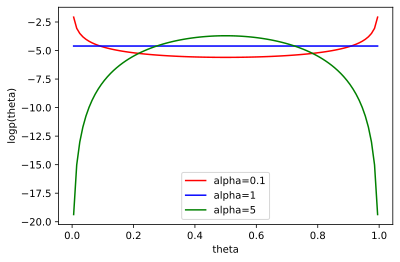

In [11]:
plt.plot(possible_pW1, calculate_logprior(0.1, possible_pW1),'red',label="alpha=0.1")
plt.plot(possible_pW1, calculate_logprior(1, possible_pW1),'blue',label="alpha=1")
plt.plot(possible_pW1, calculate_logprior(5, possible_pW1),'green',label="alpha=5")
plt.xlabel("theta")
plt.ylabel("logp(theta)")
plt.legend()

### Likelihood and production

As per the Lab 3 model, we are going to model data – sets of utterances – as a simple list of 0s and 1s: the 0s correspond to occurrences of word 0, the 1s correspond to occurrences of word 1. `loglikelihood()` takes a log probability of word 1 being produced, and use that to calculate the probability of word 0 (which is 1 minus the probability of word 1). `logproduce()` is the equivalent of `produce()` last week; it generates some data based on a log-probability of producing word 1.

In [12]:
def loglikelihood(data, logpW1):
    """Takes data (list of numbers) and hypothesis (a single log probability);
       returns the log probability of the given hypothesis generating the observed data."""
    logpW0 = log_subtract(log(1), logpW1) #probability of w0 is 1-prob of w1
    logprobs = [logpW0, logpW1]
    loglikelihoods = []
    for d in data:
        loglikelihood_this_item = logprobs[d] #d will be either 0 or 1, 
                                              #so can use as index
        loglikelihoods.append(loglikelihood_this_item)
    return sum(loglikelihoods) #summing log probabilities = 
                               #multiply non-log probabilities
    
def logproduce(logpW1, n_productions):
    """Takes log probability of word 1 being produced and the number of productions to generate;
       returns list of numbers (0 or 1), with 1 sampled with the log probability given in logpW1"""
    logpW0 = log_subtract(log(1), logpW1)
    logprobs = [logpW0, logpW1]
    data = []
    for p in range(n_productions):
        data.append(log_roulette_wheel(logprobs))
    return data

- Test out the `logproduce()` function – remember, you need to feed it a log probability, so decide on a probability for w1 and then convert it to log using the `log()` function. Check that it works as expected based on what you did last week. 
- Next, check out the `loglikelihood()` function – how does the likelihood of a set of data depend on the data and the probability of word 1? It should work in exactly the same way as last week. Remember that the likelihood function returns a log probability, so you can convert this to a probability using the `exp()` function if you want. 

*Again, everything behaves as expected. `logproduce()` produces lots of 0s if the log-probability of producing w1 is low, and lots of 1s if it is high. `loglikelihood()` says that pW1 is low then data with lots of 0s is likely and data with lots of 1s is very unlikely; if pW1 is high then data with lots of 0s is very unlikely and data with lots of 1s is likely; if pW1 is around 0.5 then all sequences of data are equally likely.*

In [13]:
print(logproduce(log(0.1), 20))
print(logproduce(log(0.9), 20))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


*`loglikelihood` says that pW1 is low then data with lots of 0s is likely and data with lots of 1s is very unlikely; if pW1 is high then data with lots of 0s is very unlikely and data with lots of 1s is likely; if pW1 is around 0.5 then all sequences of data are equally likely.*

In [14]:
print(exp(loglikelihood([0,0,0,1], log(0.1))))
print(exp(loglikelihood([1,1,1,0], log(0.1))))
print(exp(loglikelihood([0,0,0,1], log(0.9))))
print(exp(loglikelihood([1,1,1,0], log(0.9))))
print(exp(loglikelihood([0,0,0,1], log(0.5))))
print(exp(loglikelihood([1,1,1,0], log(0.5))))

0.0729
0.0009000000000000006
0.0008999999999999998
0.07289999999999998
0.0625
0.0625


*Note that if you set it up if the probability of either of the words is zero, then the code breaks because the log of zero is infinity and the computer can't handle that. In general, in the bayesian approach to learning we avoid doing anything that leads to probabilities of zero or one because of this. In essence, we always allow for some (even very small!) probability that unexpected things can happen.*

### Learning

In [15]:
def logposterior(data, logprior, possible_pW1):
    """Takes data (list of numbers), logprior (list of log prior probabilities for each hypothesis),
        and a list of possible probabilities of word 1;
       returns list of log probabilities, one per hypothesis."""
    posterior_logprobs = []
    for i in range(len(possible_pW1)):
        logpW1 = log(possible_pW1[i]) 
        logp_h = logprior[i] #prior probability of this pW1
        logp_d = loglikelihood(data, logpW1) #likelihood of data given this pW1
        posterior_logprobs.append(logp_h + logp_d) #adding logs = 
                                                   #multiplying non-logs
    return normalize_logprobs(posterior_logprobs) 
     
def loglearn(data,logprior, possible_pW1):
    """Takes data (list of numbers), logprior (list of log prior probabilities for each hypothesis),
         and a list of possible probabilities of word 1;
       Returns a single hypothesis, selected proportional to its posterior log probability."""
    posterior_logprobs = logposterior(data, logprior, possible_pW1)
    selected_index = log_roulette_wheel(posterior_logprobs)
    return possible_logpW1[selected_index]

Now we have all the bits we need to calculate the posterior probability distribution, and therefore to do learning (by picking a hypothesis (i.e. a value of pW1) based on its posterior probability). You can verify that the posterior has the right sort of shape by doing something like this (which I adapted from the Lab 3 answer sheet): 
```python
my_prior = calculate_logprior(1, possible_pW1)
my_data1 = [0] * 2 + [1] * 2
my_data2 = [0] * 4 + [1] * 4
my_data3 = [0] * 8 + [1] * 8
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)

my_logposterior1 = logposterior(my_data1,my_prior, possible_pW1)
my_logposterior2 = logposterior(my_data2,my_prior, possible_pW1)
my_logposterior3 = logposterior(my_data3,my_prior, possible_pW1)
plt.plot(possible_pW1, my_logposterior1,'grey',label='p(theta|my_data1)')
plt.plot(possible_pW1, my_logposterior2,'purple',label='p(theta|my_data2)')
plt.plot(possible_pW1, my_logposterior3,'red',label='p(theta|my_data3)')
plt.xlabel("theta")
plt.ylabel("logp(theta|data)")
plt.legend()
```

The numbers might look a bit different, because the y axis is logprobs, but the posterior should be highest where you expext it to be and low where you expect it to be low.

*So as per the suggested code, I am going to plot three posteriors on one graph, representing the posterior after learning from three different sets of data with the unfirom prior (alpha=1). The data sets all have equal numbers of word 0 and word 1, but I just double the size of the dataset each time. The y axis scale is different but apart from that everything makes sense: when we have relatively little data the peak is on 0.5 (the learner estimates that pW1 is around 0.5) but is quite wide, i.e. there's some uncertainty; the more data we add the tighter the distribution gets, as the learner becomes increasingly confident of their estimate of the word frequencies.*

data1 =  [0, 0, 1, 1]
data2 =  [0, 0, 0, 0, 1, 1, 1, 1]
data3 =  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


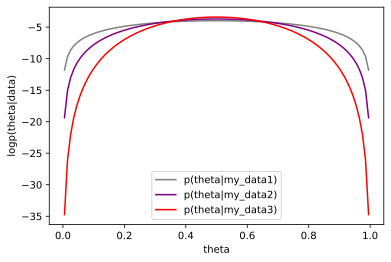

In [16]:
my_prior = calculate_logprior(1, possible_pW1)
my_data1 = [0] * 2 + [1] * 2
my_data2 = [0] * 4 + [1] * 4
my_data3 = [0] * 8 + [1] * 8
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)

my_logposterior1 = logposterior(my_data1,my_prior, possible_pW1)
my_logposterior2 = logposterior(my_data2,my_prior, possible_pW1)
my_logposterior3 = logposterior(my_data3,my_prior, possible_pW1)
plt.plot(possible_pW1, my_logposterior1,'grey',label='p(theta|my_data1)')
plt.plot(possible_pW1, my_logposterior2,'purple',label='p(theta|my_data2)')
plt.plot(possible_pW1, my_logposterior3,'red',label='p(theta|my_data3)')
plt.xlabel("theta")
plt.ylabel("logp(theta|data)")
plt.legend()

You might be asking yourself, "What does it mean to sample a value from the posterior proportional to its probability?"
The following visualisation might help make this clearer.

`loglearn()` selects a value for theta based on its posterior probability.
If you run the following code many times, you'll see that the red line (the value sampled) moves around but stays largely where the bulk of the posterior probability mass is.
This illustrates the probabilistic nature of sampling from the posterior.
(If you are curious, try it out with different priors and different datasets and try to understand what happens!)

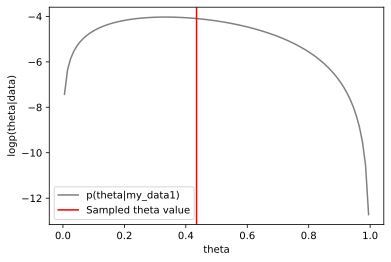

In [17]:
my_prior = calculate_logprior(1, possible_pW1)
my_data1 = [0] * 2 + [1] * 1  # The learner has observed the data [0, 0, 1]
my_logposterior1 = logposterior(my_data1,my_prior, possible_pW1)

# Sample a log value from the log posterior using loglearn(); 
# the sampled value is a log version of theta.
sampled_log_theta = loglearn(my_data1, my_prior, possible_pW1)
sampled_theta = exp(sampled_log_theta)

# Create the plot.
plt.plot(possible_pW1, my_logposterior1,'grey',label='p(theta|my_data1)')
plt.axvline(x = sampled_theta, color = 'red', label='Sampled theta value')
plt.xlabel("theta")
plt.ylabel("logp(theta|data)")
plt.legend()

### Iterated learning

At last, we have all the bits we need to do iterated learning: we can have a learner infer a value of `pW1` given some observed data, using the `loglearn()` function, then we can have that individual produce data which another individual can learn from, using the `logproduce()` function.

In [18]:
def iterate(alpha, possible_pW1, n_productions, starting_count_w1, generations):
    """
    Arguments:
        alpha: number that defines the shape of the beta distribution
        possible_pW1: the hypothesis space (possible probabilities for word 1)
        n_productions: number of productions in each generation
        starting_count_w1: number of times w1 was produced in the first generation
        generations: number of generations to run the simulation for
    Returns:
        A tuple containing pW1_accumulator (the generation-by-generation record of inferred pW1s)
        and data_accumulator (the generation-by-generation record of the number of w1s produced)
    """
    prior = calculate_logprior(alpha, possible_pW1)
    pW1_accumulator = [] # we build up lists of our inferred pW1 at each generation
    data_accumulator = [] # and number of produced word1 at each generation
    data = [1] * starting_count_w1 + [0] * (n_productions - starting_count_w1)
    for generation in range(generations):
        logpW1 = loglearn(data, prior, possible_pW1)
        data = logproduce(logpW1, n_productions)
        pW1_accumulator.append(exp(logpW1)) # will convert the inferred pW1 to a normal probability for you!
        data_accumulator.append(sum(data))
    return pW1_accumulator, data_accumulator

You can run a simulation using something like:

```python
pW1_by_generation, data_by_generation = iterate(0.1, possible_pW1, 10, 5, 20)
``` 

This will run the simulation for 20 generations, using a prior defined by alpha=0.1, each learner observes 10 data points before inferring pW1, and the initial language consists of 5 examples of word 1 (and therefore 5 of word 0). It returns two  values (this is the first time we've had a function do that, it's quite handy): a generation-by-generation record of the inferred values of pW1, and the data produced at each generation (specified as a number of occurences of word 1). It's worth plotting these values as a graph over time, but also looking at the histogram of the values to get a sense of how they are distributed overall. 

We can plot a simple line graph like this:
```python
pW1_by_generation, data_by_generation = iterate(0.1, , possible_pW1, 10, 5, 20)

plt.plot(pW1_by_generation)
plt.xlabel("generations")
plt.ylabel("theta")
```

And you can get a histogram of the `pW1` values across the entire simulation run like this:
```python
pW1_by_generation, data_by_generation = iterate(0.1, , possible_pW1, 10, 5, 1000)
plt.hist(pW1_by_generation)
plt.xlim(0, 1)
plt.xlabel("theta")
plt.ylabel("Frequency")
```
The histograms might look better if you increase the number of generations *a lot*, like to 1000, to simulate a very long chain of transmission.

If you want to run a bunch of iterated learning chains, say 10, and plot them all on the same graph, you can do something like this:
```python
for i in range(10):
    pW1_by_generation, data_by_generation = iterate(0.1, , possible_pW1, 10, 5, 20)
    plt.plot(pW1_by_generation)
plt.xlabel("generations")
plt.ylabel("theta")
```

*Basic line graph of a single chain.*

Text(0, 0.5, 'theta')

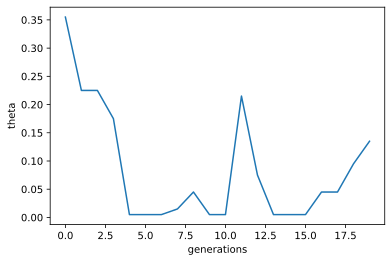

In [19]:
pW1_by_generation, data_by_generation = iterate(0.1, possible_pW1, 10, 5, 20)

plt.plot(pW1_by_generation)
plt.xlabel("generations")
plt.ylabel("theta")

*Histogram of theta values seen in a 1000-generation chain. Since the alpha is 0.1 (i.e. this is a regularity prior), I am going to colour it red for consistency with the plots in class.*

Text(0, 0.5, 'Frequency')

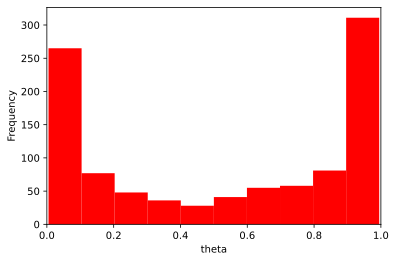

In [20]:
pW1_by_generation, data_by_generation = iterate(0.1, possible_pW1, 10, 5, 1000)
plt.hist(pW1_by_generation,color='red')
plt.xlim(0, 1)
plt.xlabel("theta")
plt.ylabel("Frequency")

*For what it's worth, here's what that same data looks like as a single line. As you can see, it jumps about every so often, but it spends most of the time with theta close to 0, or close to 1, i.e. the language spends most of its time being regular. That's what produces the skew in the histogram.*

Text(0, 0.5, 'theta')

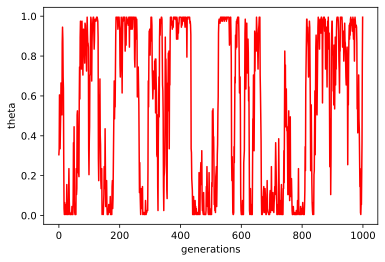

In [21]:
plt.plot(pW1_by_generation,color='red')
plt.xlabel("generations")
plt.ylabel("theta")

## Questions

Once you are happy that you understand that the log version of the code doesn't do anything different to the Lab 3 versions, and that you understand how iterated learning works, try these questions:

1. One of Reali & Griffiths’s main points was that studying learning in a single individual can be a bad way to discover their prior bias, particularly if you give them lots of data which swamps this prior bias - given enough data, learners with quite different priors look the same. Can you reproduce this effect using this code, or the Lab 3 code?

*If you want to see the code that generated the videos in lecture 4 you can look at lecture4_figures.ipynb (I was inordinately proud of those videos). Here I'll just do the low-tech version and show that for small amounts of data you can see the effect of the prior, but with large amounts of data it becomes much more subtle.*

*First, here are the posteriors for learners with 3 different priors exposed to a small amount of data, where w1 is more common than w0. Again, the y-axis looks different so it's initially a bit confusing, but if you just looks at the shape you can see what's going on. The blue line (uniform prior) is pretty flat, but the high point is around the input frequency (given by the dashed line). The red line (regularity prior) is higher than the blue line for extreme values of theta, e.g. theta values which overestimate the frequency of word 1, e.g. up around 0.9 or 0.95 - it's showing the preference for regularity. And the green line (variability prior) is way lower at extreme values, and peaks around theta = 0.5, i.e. the most variable system.*

small_data =  [0, 1, 1, 1]


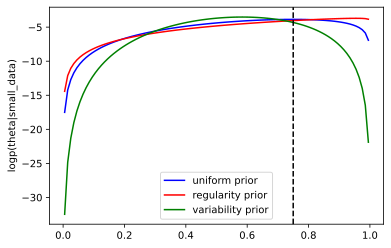

In [22]:
uniform_prior = calculate_logprior(1, possible_pW1)
regularity_prior = calculate_logprior(0.1, possible_pW1)
variability_prior = calculate_logprior(5, possible_pW1)

small_data = [0] * 1 + [1] * 3

print('small_data = ',small_data)


logposterior1 = logposterior(small_data,uniform_prior, possible_pW1)
logposterior2 = logposterior(small_data,regularity_prior, possible_pW1)
logposterior3 = logposterior(small_data,variability_prior, possible_pW1)

plt.plot(possible_pW1, logposterior1,'blue',label='uniform prior')
plt.plot(possible_pW1, logposterior2,'red',label='regularity prior')
plt.plot(possible_pW1, logposterior3,'green',label='variability prior')
plt.axvline(x=3/4,color='black',linestyle='--') 
plt.ylabel("logp(theta|small_data)")
plt.legend()

*If you find it hard to look at the graph of log probabilities you can just convert them back to normal probabilities (e.g. using a for loop) and plot those, hopefully it looks familiar!:*

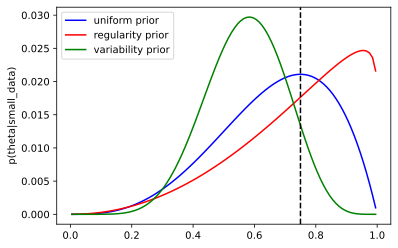

In [23]:
posterior1 = []
def logps_to_ps(logps):
    ps = []
    for logp in logps:
        ps.append(exp(logp))
    return ps


posterior1 = logps_to_ps(logposterior1)
posterior2 = logps_to_ps(logposterior2)
posterior3 = logps_to_ps(logposterior3)

plt.plot(possible_pW1, posterior1,'blue',label='uniform prior')
plt.plot(possible_pW1, posterior2,'red',label='regularity prior')
plt.plot(possible_pW1, posterior3,'green',label='variability prior')
plt.axvline(x=3/4,color='black',linestyle='--') 
plt.ylabel("p(theta|small_data)")
plt.legend()


*And now here the three posteriors are with a much larger set of data - the ratio of w1 to w0 is still 3 to 1, but now we have 100 data items, and the effect of the prior is hard to see, the lines are very nearly on top of each other.*

big_data =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


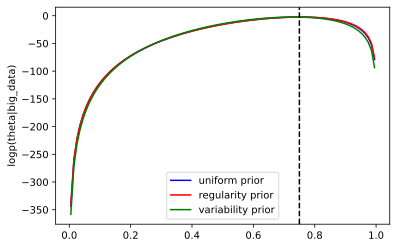

In [24]:
big_data = [0] * 25 + [1] * 75

print('big_data = ',big_data)


logposterior4 = logposterior(big_data,uniform_prior, possible_pW1)
logposterior5 = logposterior(big_data,regularity_prior, possible_pW1)
logposterior6 = logposterior(big_data,variability_prior, possible_pW1)

plt.plot(possible_pW1, logposterior4,'blue',label='uniform prior')
plt.plot(possible_pW1, logposterior5,'red',label='regularity prior')
plt.plot(possible_pW1, logposterior6,'green',label='variability prior')
plt.axvline(x=3/4,color='black',linestyle='--') 
plt.ylabel("logp(theta|big_data)")
plt.legend()

2. Iterated learning can potentially give a clearer picture of prior bias. Try running some simulations for 10 generations, with 10 data points passed from generation to generation, starting each simulation with 5 instances of w1 and 5 of w0. How does changing the prior change the results?  Try alpha=0.1, alpha=1, and alpha=5. Are the differences between different priors obvious after generation 1, or do they become more apparent over generations? Try running some very long chains (e.g. 1000 generations) with different priors and plotting histograms of the `pW1` values - can you see the effect of different priors here?

*OK, first I'll try some short chains and plot all 3 sets of results as lines. It's worth running this a few times to see how much things jump around on different runs! Depending on whether you get lucky or not, you might see that the red line tends to end up going towards either theta=0 or theta=1 and then sticking there (i.e. the regularity bias in learners eventually makes the language become regular), but that effect tends not to be visible at generation 1, and it varies quite a lot from run to run.*

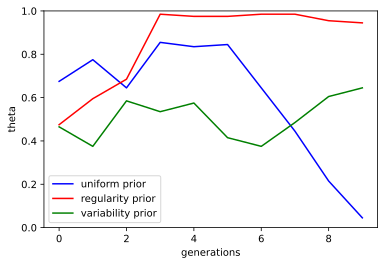

In [25]:
uniform_prior_pW1_by_generation, uniform_prior_data_by_generation = iterate(1, possible_pW1, 10, 5, 10)
regularity_prior_pW1_by_generation, regularity_prior_data_by_generation = iterate(0.1, possible_pW1, 10, 5, 10)
variability_prior_pW1_by_generation, variability_prior_data_by_generation = iterate(5, possible_pW1, 10, 5, 10)

plt.plot(uniform_prior_pW1_by_generation,'blue',label='uniform prior')
plt.plot(regularity_prior_pW1_by_generation,'red',label='regularity prior')
plt.plot(variability_prior_pW1_by_generation,'green',label='variability prior')
plt.xlabel("generations")
plt.ylabel("theta")
plt.ylim(0,1) #I am fixing the limits of the y-axis so it doesn't jump around.
plt.legend()

*I find the histograms much clearer - 1000 generations, plot all the theta values we see along the chain.*

In [26]:
uniform_prior_pW1_by_generation, uniform_prior_data_by_generation = iterate(1, possible_pW1, 10, 5, 1000)
regularity_prior_pW1_by_generation, regularity_prior_data_by_generation = iterate(0.1, possible_pW1, 10, 5, 1000)
variability_prior_pW1_by_generation, variability_prior_data_by_generation = iterate(5, possible_pW1, 10, 5, 1000)

Text(0, 0.5, 'Frequency')

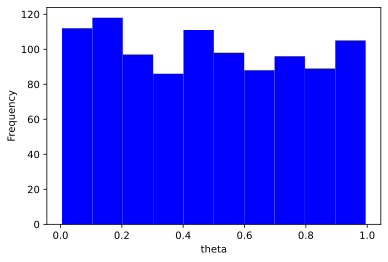

In [27]:
plt.hist(uniform_prior_pW1_by_generation,color='blue',label='uniform prior')
plt.xlabel("theta")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

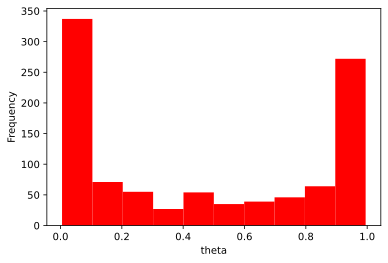

In [28]:
plt.hist(regularity_prior_pW1_by_generation,color='red',label='regularity prior')
plt.xlabel("theta")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

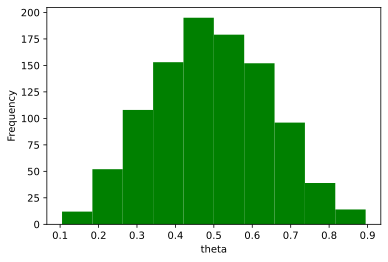

In [29]:
plt.hist(variability_prior_pW1_by_generation,color='green',label='variability prior')
plt.xlabel("theta")
plt.ylabel("Frequency")

*And for completeness, here are those line graphs - I think the histograms are easier to interpret, but you can see the green line mainly stays in the middle (i.e. near theta=0.5) while the red line tends to spend lots of time at extreme (i.e. regular) values.*

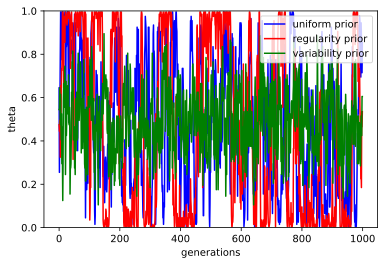

In [30]:
plt.plot(uniform_prior_pW1_by_generation,'blue',label='uniform prior')
plt.plot(regularity_prior_pW1_by_generation,'red',label='regularity prior')
plt.plot(variability_prior_pW1_by_generation,'green',label='variability prior')
plt.xlabel("generations")
plt.ylabel("theta")
plt.ylim(0,1) #I am fixing the limits of the y-axis so it doesn't jump around.
plt.legend()

3. Now try messing with the amount of data that is passed from generation to generation (remember to change the starting count of the w1 so you can compare between the different data set sizes fairly). What happens if you pass more data between generations? What happens if you pass less? What happens if you pass no data from generation to generation? What would this latter setting correspond to in the real world?

*I am actually going to start with a line graph, 100 data points passed from generation to generation (previously there were 10). This will take a little while to run.*

In [31]:
uniform_prior_pW1_by_generation, uniform_prior_data_by_generation = iterate(1, possible_pW1, 100, 50, 1000)
regularity_prior_pW1_by_generation, regularity_prior_data_by_generation = iterate(0.1, possible_pW1, 100, 50, 1000)
variability_prior_pW1_by_generation, variability_prior_data_by_generation = iterate(5, possible_pW1, 100, 50, 1000)

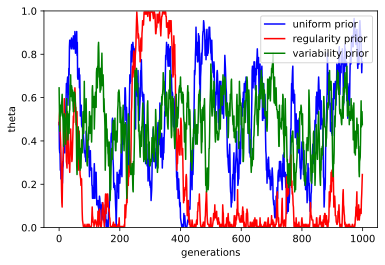

In [32]:
plt.plot(uniform_prior_pW1_by_generation,'blue',label='uniform prior')
plt.plot(regularity_prior_pW1_by_generation,'red',label='regularity prior')
plt.plot(variability_prior_pW1_by_generation,'green',label='variability prior')
plt.xlabel("generations")
plt.ylabel("theta")
plt.ylim(0,1) #I am fixing the limits of the y-axis so it doesn't jump around.
plt.legend()

*So the first thing to notice is that, with 100 data points passing from generation to generation, things change much more slowly - the learners get a better chance to estimate their parent's language, so the line jumps about less dramatically. But even so, we can still see that the green line spends most of its time in the middle, whereas the red line seems drawn to the extremes - so you can still see the influence of the prior in the long run, even though at 100 data points the influence of the prior on each learner is very subtle (as we established above). Hopefully we can see this in the histograms still.*

Text(0, 0.5, 'Frequency')

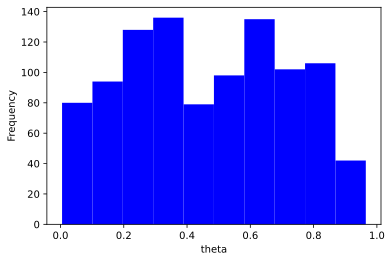

In [33]:
plt.hist(uniform_prior_pW1_by_generation,color='blue',label='uniform prior')
plt.xlabel("theta")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

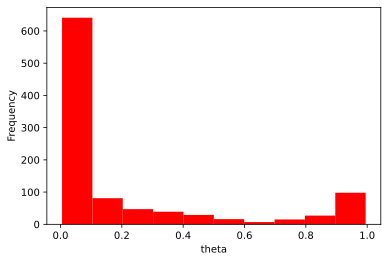

In [34]:
plt.hist(regularity_prior_pW1_by_generation,color='red',label='regularity prior')
plt.xlabel("theta")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

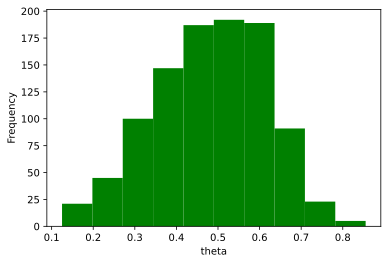

In [35]:
plt.hist(variability_prior_pW1_by_generation,color='green',label='variability prior')
plt.xlabel("theta")
plt.ylabel("Frequency")

*One thing to note is that those histograms look less neat and a bit less like the prior - that's because the languages change more slowly. If you ran these simulations for 10,000 generations or 100,000 generations the histograms would look much closer to the prior.*

4. If iterated learning is a model of language transmission in the real-world, what do these results imply about the kinds of languages we see in the wild, and how they relate to the prior biases of real language learners?   

*This is a conceptual question rather than a coding one. I'll be interested and happy to discuss this with you, and we'll come back to it in the later lectures, but it seems like this model predicts that, if languages are transmitted by iterated learning, the way they work should be a very clear reflection of the prior biases of language learners - actually, maybe even a clearer reflection than you can get by studying learning in individuals.*